In [1]:
# clustering snippet (notebook cell)
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

df = pd.read_csv("../data/processed/ev_population_features.csv")

# Group by state and compute adoption metrics
agg = df.groupby("State").agg(
    ev_count=("DOL Vehicle ID","count"),
    avg_range=("Electric Range","mean"),
    avg_msrp=("Base MSRP","mean")
).fillna(0)

scaler = StandardScaler()
X = scaler.fit_transform(agg)

# try 2..6 clusters and pick silhouette
best_k, best_score = 2, -1
for k in range(2,7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X)
    score = silhouette_score(X, km.labels_)
    if score > best_score:
        best_k, best_score = k, score

km = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit(X)
agg["cluster"] = km.labels_

print("Chosen k:", best_k, "silhouette:", round(best_score,3))
agg.reset_index().to_csv("../reports/figures/state_clusters.csv", index=False)


Chosen k: 2 silhouette: 0.765


c:\Users\jatin\OneDrive\Desktop\Projects\electric-vehicle-analysis\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\jatin\OneDrive\Desktop\Projects\electric-vehicle-analysis\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\jatin\OneDrive\Desktop\Projects\electric-vehicle-analysis\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


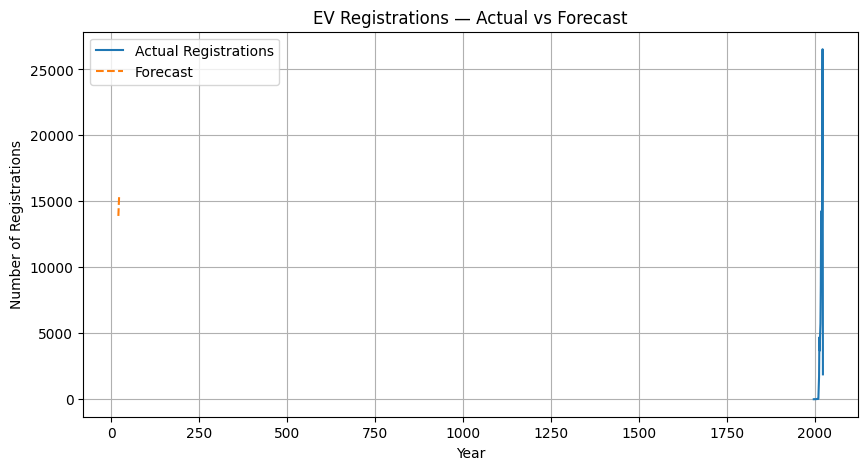

In [5]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# 1. Load the dataset
df = pd.read_csv("../data/processed/ev_population_features.csv")

# 2. Group by Model Year instead of reg_year
ts = df.groupby("Model Year").size().rename("count").sort_index()

# 3. Build ETS model
model = ExponentialSmoothing(
    ts,
    trend="add",
    seasonal=None,
    initialization_method="estimated"
)

# 4. Fit model
fit = model.fit()

# 5. Forecast next 3 years
pred = fit.forecast(3)

# 6. Plotting
plt.figure(figsize=(10,5))
plt.plot(ts.index, ts.values, label="Actual Registrations")
plt.plot(pred.index, pred.values, label="Forecast", linestyle="--")
plt.legend()
plt.title("EV Registrations — Actual vs Forecast")
plt.xlabel("Year")
plt.ylabel("Number of Registrations")
plt.grid(True)

plt.savefig("../reports/figures/ev_forecast.png", dpi=200)
plt.show()


c:\Users\jatin\OneDrive\Desktop\Projects\electric-vehicle-analysis\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|===================| 22498/22527 [01:20<00:00]        

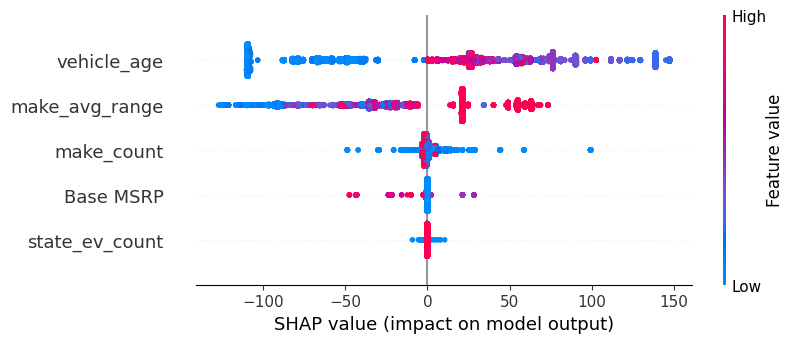

In [4]:
# simple RF + SHAP
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import shap
from sklearn.model_selection import train_test_split

df = pd.read_csv("../data/processed/ev_population_features.csv")
features = ["make_count","make_avg_range","state_ev_count","vehicle_age","Base MSRP"]
df = df.dropna(subset=features+["Electric Range"])
X = df[features]
y = df["Electric Range"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)

explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values)
